# CNN for AED with Keras/TensorFlow

Date: November 11, 2018 and February 27, 2019

Neural network: three convolution layers and three fully connected layers

Classification of acoustic events:

- Piano music
- Framenco guitar music
- Classical guitar music
- Blues hars music
- Tin whistle music
- Silence

## Preparing data set for CNN

In [8]:
DATASET_FOLDER = '../dataset/data_music'

%run ../oscilloscope/script/dataset.py

ds = DataSet(DATASET_FOLDER)
train_data, train_labels, test_data, test_labels = ds.generate()
shape = ds.shape
class_labels = ds.class_labels

In [9]:
shape

(64, 40)

### CNN model

In [10]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(*shape, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 38, 8)         80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 19, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 17, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 8, 16)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 6, 32)         4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 3, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
__________

In [11]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

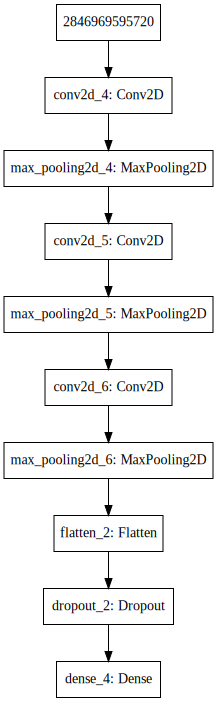

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [13]:
EPOCHS = 60
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 384 samples, validate on 216 samples
Epoch 1/60
384/384 [==============================] - 14s 35ms/step - loss: 1.6652 - acc: 0.3203 - val_loss: 1.4115 - val_acc: 0.4815
Epoch 2/60
384/384 [==============================] - 12s 31ms/step - loss: 1.3205 - acc: 0.5339 - val_loss: 1.1058 - val_acc: 0.7083
Epoch 3/60
384/384 [==============================] - 12s 32ms/step - loss: 1.0936 - acc: 0.5729 - val_loss: 0.9130 - val_acc: 0.6898
Epoch 4/60
384/384 [==============================] - 12s 32ms/step - loss: 0.9621 - acc: 0.6198 - val_loss: 0.8234 - val_acc: 0.6806
Epoch 5/60
384/384 [==============================] - 13s 33ms/step - loss: 0.8257 - acc: 0.7057 - val_loss: 0.7567 - val_acc: 0.7130
Epoch 6/60
384/384 [==============================] - 12s 31ms/step - loss: 0.7132 - acc: 0.7344 - val_loss: 0.6731 - val_acc: 0.7269
Epoch 7/60
384/384 [==============================] - 13s 33ms/step - loss: 0.6840 - acc: 0.7422 - val_loss: 0.5709 - val_acc: 0.7731
Epoch 8/60
384/3

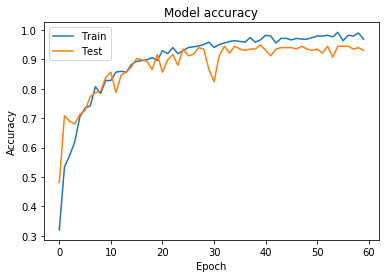

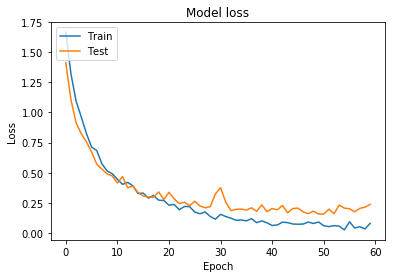

In [14]:
%run history.py
%matplotlib inline

plot_accuracy(history)
plot_loss(history)

## Save the model

In [15]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = DATASET_FOLDER + '/cnn_for_aed_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [16]:
del model
model = models.load_model(filename)

## Confirmation

In [17]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(384, 64, 40, 1)

In [18]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [19]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [20]:
class_labels

['piano',
 'classical_guitar',
 'framenco_guitar',
 'blues_harp',
 'tin_whistle',
 'silence']

In [21]:
(activations[-1][:10]*100).astype(int)

array([[  0,   0,   0,   0,  99,   0],
       [  0,   0,  94,   4,   0,   0],
       [  0,  99,   0,   0,   0,   0],
       [  0,   4,   0,  95,   0,   0],
       [  0,   0,  98,   0,   0,   0],
       [ 99,   0,   0,   0,   0,   0],
       [  0,   0,  99,   0,   0,   0],
       [  0,   0,   0,  99,   0,   0],
       [  0,   0,   0,   0, 100,   0],
       [  0,  73,  26,   0,   0,   0]])

In [22]:
test_labels[:10].astype(int)

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0]])

In [23]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]))
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'classical_guitar'

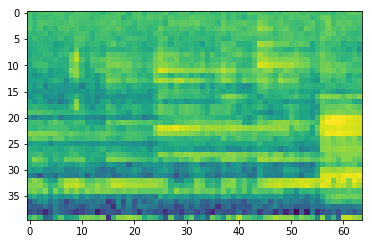

In [28]:
image_number = 2

plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

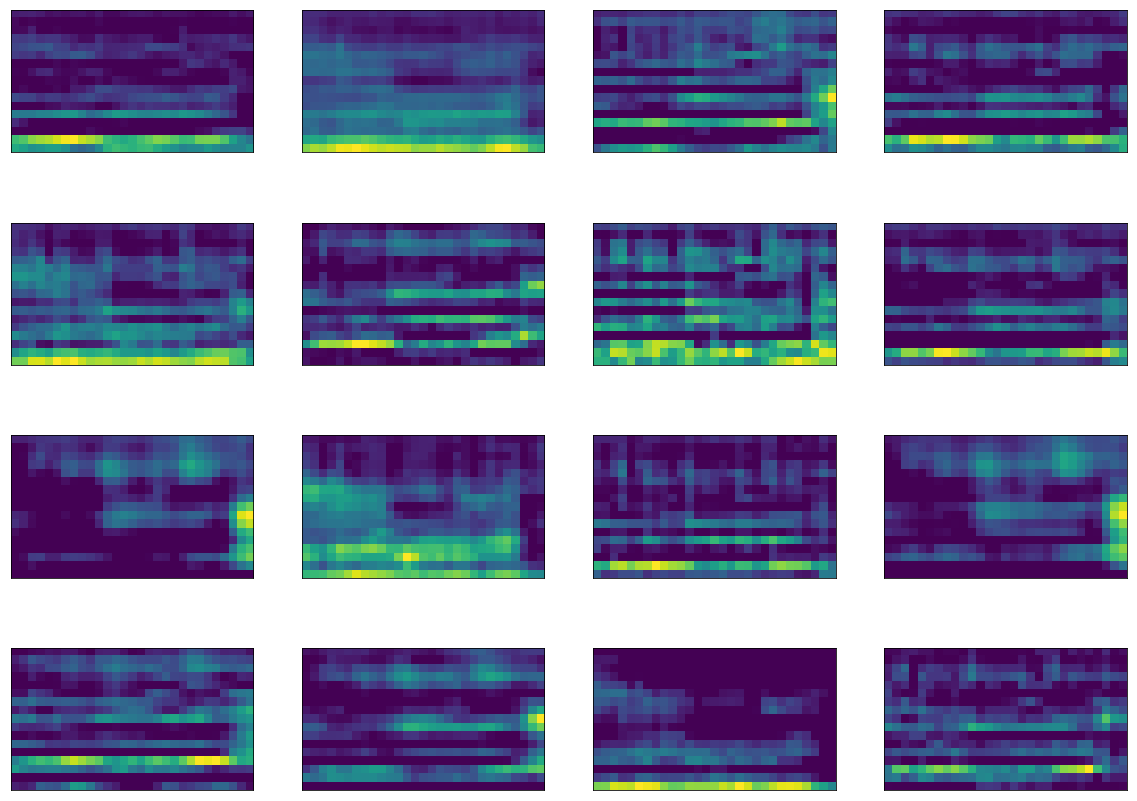

In [29]:
plot_layer(activations, image_number, 2)

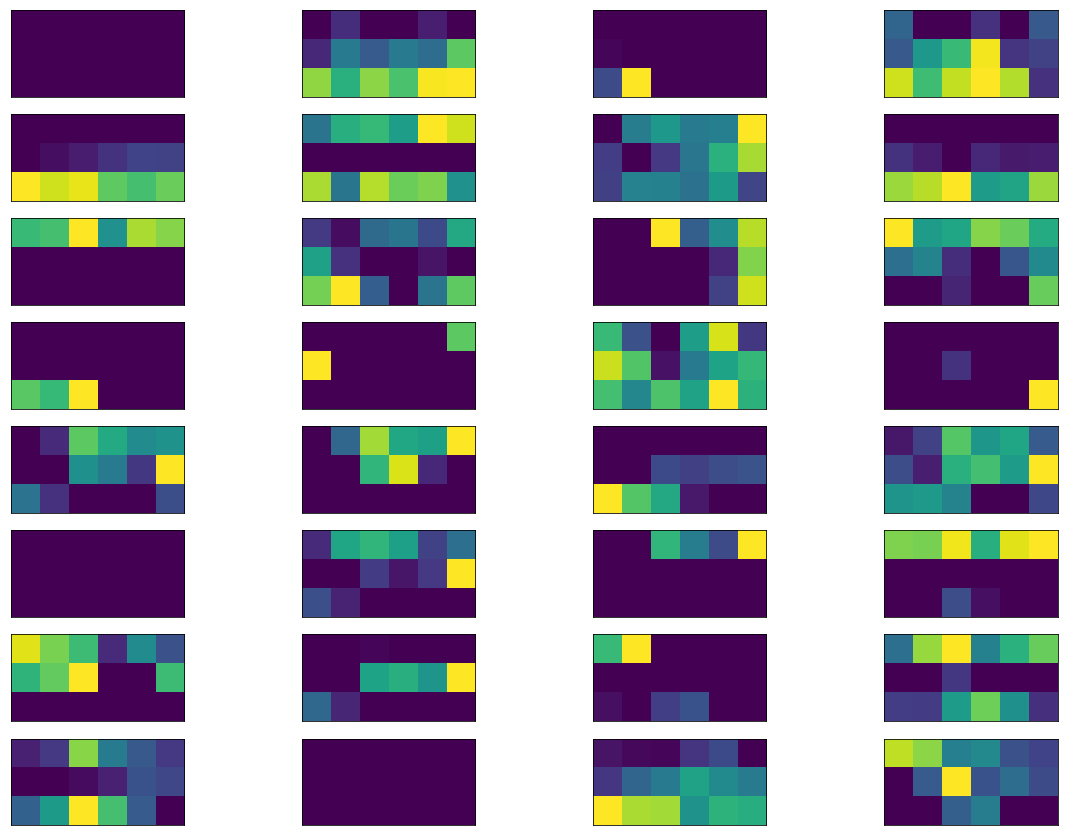

In [30]:
plot_layer(activations, image_number, 5)